# ZeroShot (Algo 1)

    for total_batches in range(total_n_pseudo_batches):
    
        z = tf.random.normal([batch_size, z_dim])
        pseudo_images = get_gen_images(z)
        teacher_logits, *teacher_activations = get_model_outputs(teacher_model, pseudo_images, mode=0)

        #generator training
        for ng in range(ng_batches):
            student_logits, *student_activations = get_model_outputs(student_model, pseudo_images, mode=1)
            generator_loss = generator_loss(teacher_logits, student_logits)

            #################################
            # BACK PROP AND tick schedulers #
            #################################  

        for ns in range(ns_batches):
            student_logits, *student_activations = get_model_outputs(student_model, pseudo_images, mode=1)
            student_loss = student_loss(teacher_logits, teacher_activations, 
                                        student_logits, student_activations, attn_beta)

            #################################
            # BACK PROP AND tick schedulers #
            #################################   

        ######################################################
        ### Val accuracy computation and best model saving ###
        ######################################################    

In [1]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.utils import normalize

def kd_loss(p_true, p_pred):
    """
    Kullback Leibler divergence loss
    Args:
        p_true:
        p_pred:
    Ref:
    https://www.tensorflow.org/versions/r1.14/api_docs/python/tf/keras/losses/KLDivergence
    """
    return KLDivergence()(p_true, p_pred)

def generator_loss_fn(t_logits, s_logits, temp=1):

	loss = kd_loss(
            tf.math.softmax(t_logits / temp) ,
            tf.math.softmax(s_logits / temp))

	g_loss = -loss

	return g_loss


def student_loss_fn(t_logits, t_acts, s_logits, s_acts, beta, temp=1):
    """
    The student loss function used in
        - zero-shot learning
        - Knowledge-distillaton with attention term (KD-AT)
        - few-shot learning, few samples as KD-AT
    See Section 3.2, Eq. 1
    Args:
        t_logits: Teacher logits
        t_acts:  list of teacher activation layer output
        s_logits: Student logits
        s_acts: list of student activation layer output
        beta: hyper-parameter for tuning the weight of the attention term
    Return:
        loss
    """
    loss = kd_loss(
            tf.math.softmax(t_logits / temp) ,
            tf.math.softmax(s_logits / temp))

    if beta != 0.0:
        att_loss = 0.0
        for t_act, s_act in zip(t_acts, s_acts):
            att_loss += attention_loss(t_act, s_act)

        loss += beta * att_loss

    return loss

def __spatial_attention_map(act_tensor, p=2):
    """
    Spatial attention mapping function to map the activation tensor with shape
    (H, W, C) to (H, W).
    We employed:
        sum of absolute values raised to the power of 2
    The f(A_{l}) is the paper of replication
    Args:
        act_tensor: activation tensor with shape (H, W, C)
    Return:
        a spatial attention map with shape (H, W)
    Migration:
        corr. to f_act
    """

    out = tf.pow(act_tensor, p)
    out = tf.reduce_mean(out, axis=-1)
    # flatten it
    out = tf.reshape(out, [out.shape[0], -1])

    # renormalize them
    out = tf.linalg.l2_normalize(out)
    return out

def attention_loss(act1, act2):
    """
    Return the activation loss. The loss is the L2 distances between two
    activation map
    Args:
        act_map_1:
        act_map_2:
    Return:
        a floating point number representing the loss. As we use tensorflow,
        the floating point number would be a number hold in tf.Tensor
    Bug:
        1. use this with beta = 250 will blow up the err and the grad will explode
        2. their implementation not using beta = 250
    Ref:
    https://github.com/szagoruyko/attention-transfer/blob/893df5488f93691799f082a70e2521a9dc2ddf2d/utils.py#L22
    """
    # get the activation map first
    act_map_1 = __spatial_attention_map(act1)
    act_map_2 = __spatial_attention_map(act2)

    if False: # paper impl.
        # calculate vector norm of vectorized matrix
        out = tf.pow(act_map_1 - act_map_2, 2)
        out = tf.reduce_sum(out)
        ret = tf.sqrt(out)
    else:
        # their code impl
        out = tf.pow(act_map_1 - act_map_2, 2)
        out = tf.reduce_mean(out)
        ret = out
    return ret

In [2]:
# -*- coding: utf-8 -*-
"""
Wide Residual Network models for Keras.
This implementation follows the implementation of the authors' lua version.
Missing info if only check with the author paper:
    1. Add batchnorm + relu before the avg_pool layer
    2. conv1x1 used to adjust the input output size.
       it is called down sampling in the paper
       no bn+relu before this down sample conv1x1
Reference:
    - [Wide Residual Networks](https://arxiv.org/abs/1605.07146)
    - https://towardsdatascience.com/review-wrns-wide-residual-networks-image-classification-d3feb3fb2004
    - https://github.com/szagoruyko/wide-residual-networks
    - https://github.com/szagoruyko/wide-residual-networks/blob/master/models/wide-resnet.lua
    - https://github.com/xternalz/WideResNet-pytorch/blob/master/wideresnet.py
Notes:
    1. Used Pre-Activation ResNet
        performing batch norm and ReLU before convolution
        i.e. BN-ReLU-Conv
TODO:
    2. model.add_lost
Visualize the network:
    ```
    $ python wide_resnet.py
    ```
"""
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Layer
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K


class Identity(Layer):
    """
    Identity layer, like nn.Identity in pytorch
    """

    def __init__(self, **kwargs):
        super(Identity, self).__init__(**kwargs)

    def call(self, x):
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

def WideResidualNetwork(depth=28, width=8, dropout_rate=0.0,
                        input_shape=None, classes=10, weight_decay=0.0,
                        has_softmax=True, output_activations=False):
    """
    Builder function to make wide-residual network
    """
    # --------------------------------------------------------------------------
    # input args checking
    if (has_softmax and output_activations):
        # FIXME: Fix the wordings
        raise ValueError("we should not need both softmax and activations at the same time.")

    if (depth - 4) % 6 != 0:
        raise ValueError('Depth of the network must be such that (depth - 4)'
                         'should be divisible by 6.')
    # ----------------------------------------------------------------------------
    # make model name
    model_name = 'wide-resnet-{}-{}'.format(depth, width)


    img_input = Input(shape=input_shape)

    ret = __create_wide_residual_network(classes, img_input,
            depth=depth,
            width=width,
            dropout=dropout_rate,
            weight_decay=weight_decay,
            has_softmax=has_softmax,
            output_activations=output_activations,
            model_name=model_name)


    return ret

def __conv1_block(input_, weight_decay=0.0):
    """
    The first convolution layer of WRN.
    As the paper call it conv1 group, we call it conv1_block for convention
    """

    x = Conv2D(16, kernel_size=3, padding='same', use_bias=False,
               kernel_regularizer=regularizers.l2(weight_decay))(input_)
    return x


def __basic_residual_basic_block(input_, nInputPlane, nOutputPlane, strides, dropout=0.0, weight_decay=0.0):
    """
    See [Wide Residual Networks] Figure 1(a); B(3, 3) implementation
    TODO:
        doc
    """

    # ==================
    # residual blocks
    # ==================
    # Pre-Activation
    x = BatchNormalization()(input_)
    x = Activation('relu')(x)
    short_circuit_start = x  # mark this block as the short_circuit_start point
    x = Conv2D(nOutputPlane, kernel_size=3, strides=strides, padding='same',
               use_bias=False, kernel_regularizer=regularizers.l2(weight_decay))(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Mentioned in the paper section 2.4
    # A dropout layer shoud be after ReLU to perturb batch normalization in the
    # next residual block and prevent it from overfitting.
    if dropout > 0:
        x = Dropout(dropout)(x)

    x = Conv2D(nOutputPlane, kernel_size=3, strides=1, padding="same",
               use_bias=False, kernel_regularizer=regularizers.l2(weight_decay))(x)

    # ==================
    # short circuit
    # ==================
    if nInputPlane != nOutputPlane:
        init = Conv2D(nOutputPlane, kernel_size=1, strides=strides,
                      use_bias=False, kernel_regularizer=regularizers.l2(weight_decay))(short_circuit_start)
    else:
        init = input_

    m = Add()([init, x])
    return m

def __residual_block_group(input_, nInputPlane, nOutputPlane, count, strides, dropout=0.0, weight_decay=0.0):
    """
    For stacking blocks
    TODO:
        doc
    """
    x = input_
    for i in range(count):
        if i == 0:
            x = __basic_residual_basic_block(
                    x, nInputPlane, nOutputPlane, strides, dropout=dropout, weight_decay=weight_decay)
        else:
            # As the first block in group resolved unequal input and output
            # on this block, the strides will be 1 for this
            x = __basic_residual_basic_block(
                x, nOutputPlane, nOutputPlane, strides=1, dropout=dropout, weight_decay=weight_decay)
    return x


def __create_wide_residual_network(nb_classes, img_input, depth=28,
                                   width=8, dropout=0.0,
                                   weight_decay=0.0,
                                   has_softmax=True,
                                   output_activations=False, model_name=None):
    ''' Creates a Wide Residual Network with specified parameters
    Args:
        nb_classes: Number of output classes
        img_input: Input layer
        depth: Depth of the network. Compute N = (n - 4) / 6.
               For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
               For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
               For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
        width: Width of the network.
        dropout: Adds dropout if value is greater than 0.0
    Returns:
        a Keras Model
    Notes:
        N is a number of blocks in group.
        minus 4 as we have
            1. 1 conv3x3 in conv1_block group
            2. 1 conv in each group for upsample / downsample in shortcut
               Each group has exactly one conv1x1 as shortcut size tunning
    '''
    N = (depth - 4) // 6

    x = __conv1_block(img_input, weight_decay=weight_decay)

    nChannels = [16, 16*width, 32*width, 64*width]

    # Block Group: conv2
    x = __residual_block_group(x, nChannels[0], nChannels[1],
                               count=N, strides=1, dropout=dropout,
                               weight_decay=weight_decay)
    act1 = x
    # att1 = Identity(name='attention1')(x)  # Identity layer


    # Block Group: conv3
    x = __residual_block_group(x, nChannels[1], nChannels[2],
                               count=N, strides=2, dropout=dropout,
                               weight_decay=weight_decay)
    act2 = x
    # att2 = Identity(name='attention2')(x)  # Identity layer

    # Block Group: conv4
    x = __residual_block_group(x, nChannels[2], nChannels[3],
                               count=N, strides=2, dropout=dropout,
                               weight_decay=weight_decay)
    act3 = x
    # att3 = Identity(name='attention3')(x)  # Identity layer


    # Avg pooling + fully connected layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)    # relu is a must add otherwise cannot train
    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    # Final classification layer
    x = Dense(nb_classes, name='logits')(x)
    if has_softmax and not output_activations:
        x = Softmax(axis=-1)(x)

    # make model as the return
    if output_activations:
        ret = Model(inputs=img_input, outputs=[x, act1, act2, act3], name=model_name)
    else:
        ret = Model(inputs=img_input, outputs=x, name=model_name)

    return ret

# ========================================================

if __name__ == "__main__":
    pass
    n = 16
    k = 2
    model = WideResidualNetwork(n, k, input_shape=(32, 32, 3), dropout_rate=0.0, weight_decay=0.002)
    model.summary()
    # model.load_weights('test.h5')
    # # plt_name = "WRN-{}-{}.pdf".format(n, k)
    # # from tensorflow.keras.utils import plot_model
    # # plot_model(model, plt_name, show_shapes=True, show_layer_names=True)
    # # model.save_weights('test.h5')

    # # model2 = WideResidualNetwork(n, k, input_shape=(32, 32, 3), dropout_rate=0.0, output_activations=True)
    # # # from tensorflow.keras.utils import plot_model
    # # # plt_name = "new-WRN-{}-{}.pdf".format(n, k)
    # # # plot_model(model, plt_name, show_shapes=True, show_layer_names=True)

Model: "wide-resnet-16-2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
___________________________________________________________________________________

In [7]:
"""
The generator use to provide a training sample that teacher and students has
the most difference estimation distribution.
TODO:
    Understand how this structure comes
Quote:
    We use a generic generator with only three convolutional layers,
    and our input noise z has 100 dimensions
"""
import tensorflow as tf
import tensorflow.keras.backend as K
# from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Reshape


def NavieGenerator(input_dim=100):
    model = tf.keras.Sequential()
    model.add(Dense(8 * 8 * 128, input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((8, 8, 128)))
    assert model.output_shape == (None, 8, 8, 128)

    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    assert model.output_shape == (None, 32, 32, 3)
    return model

# function alias
generator = NavieGenerator

In [8]:
import tensorflow as tf
#from net.generator import NavieGenerator
#####from utils.cosine_anealing import CosineAnnealingScheduler
#####from utils.losses import student_loss_fn, generator_loss_fn
#from utils.losses import student_loss_fn
from tensorflow.keras.optimizers import Adam
#from net.wide_resnet import WideResidualNetwork
from tensorflow.keras.experimental import CosineDecay
import numpy as np

In [9]:
tf.__version__

'2.0.0'

In [11]:
z_dim = 100
batch_size = 128
ng_batches = 1
ns_batches = 10
attn_beta = 250
total_n_pseudo_batches = 80000
student_lr = 1e-3
generator_lr = 2e-3

teacher = WideResidualNetwork(40, 2, input_shape=(32, 32, 3), dropout_rate=0.0, has_softmax=False, output_activations=True)
#teacher.load_weights('exp1_wrn-16-1-seed23_cifar10_WRN-16-1-seed23_model.171.h5')
teacher.load_weights('cifar10_WRN-40-2-seed23_model.186.h5')
teacher.trainable = False

student = WideResidualNetwork(16, 1, input_shape=(32, 32, 3), dropout_rate=0.0, has_softmax=False, output_activations=True)
student_optimizer = Adam(learning_rate=CosineDecay(student_lr, total_n_pseudo_batches*ns_batches))

generator = NavieGenerator(input_dim=100)
generator_optimizer = Adam(learning_rate=CosineDecay(generator_lr, total_n_pseudo_batches))


# Generator loss metrics
g_loss_met = tf.keras.metrics.Mean()
# Student loss metrics
stu_loss_met = tf.keras.metrics.Mean()

In [12]:
# collect noise samples here
allZ = []
r=[]
for total_batches in range(total_n_pseudo_batches):
    # sample from latern space to make an image
    z = tf.random.normal([batch_size, z_dim])
    
    allZ.append(z)
    #pseudo_imgs = generator(z)
    # Generator training
    generator.trainable = True
    student.trainable = False
    with tf.GradientTape() as tape:
        pseudo_imgs = generator(z)
        t_logits, *t_acts = teacher(pseudo_imgs)
        s_logits, *_ = student(pseudo_imgs)

        # calculate the generator loss
        sloss = generator_loss_fn(t_logits, s_logits)

        # The grad for generator
        grads = tape.gradient(sloss, generator.trainable_weights)
        #grads, _ = tf.clip_by_global_norm(grads, 5.0)
        #generator_optimizer.minimize(sloss_fn, var_list_fn)
        #generator_optimizer.get_gradients(loss, generator.trainable_weights)
        # update the generator paramter with the gradient
        for ng in range(ng_batches):
            generator_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

        g_loss_met(sloss)

    print('step %s: generator mean loss = %s' % (total_batches, g_loss_met.result().numpy()))
    # ==========================================================================

    # Student training
    generator.trainable = False
    student.trainable = True
    for ns in range(ns_batches):
        #print(pseudo_imgs.shape)

        #t_logits, *t_acts = teacher(pseudo_imgs)
        with tf.GradientTape() as tape:
            pseudo_imgs = generator(z)
            t_logits, *t_acts = teacher(pseudo_imgs)
            s_logits, *s_acts = student(pseudo_imgs)
            loss = student_loss_fn(t_logits, t_acts, s_logits, s_acts, attn_beta)

            # The grad for student
            grads = tape.gradient(loss, student.trainable_weights)
            #grads, _ = tf.clip_by_global_norm(grads, 5.0)
            # Apply grad for student
            student_optimizer.apply_gradients(zip(grads, student.trainable_weights))

            stu_loss_met(loss)
    print(np.argmax(t_logits, axis=-1))
    print(np.argmax(s_logits, axis=-1))
    print('step %s-%s: studnt mean loss = %s' % (total_batches, ns, stu_loss_met.result().numpy()))
    r.append([g_loss_met.result().numpy(),stu_loss_met.result().numpy()])
    stu_loss_met.reset_states()
    g_loss_met.reset_states()

step 0: generator mean loss = -2.282476
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
step 0-9: studnt mean loss = 1.0006514
step 1: generator mean loss = -0.030416649
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3

KeyboardInterrupt: 

In [13]:
r

[[-2.282476, 1.0006514],
 [-0.030416649, 0.30817515],
 [-0.17294392, 9.632488],
 [-9.238077, 3.0614452],
 [-3.2060957, 3.8781276],
 [-2.8374429, 11.735017]]

In [14]:
import matplotlib.pyplot as q
q.plot(np.array(r)[:25,1])

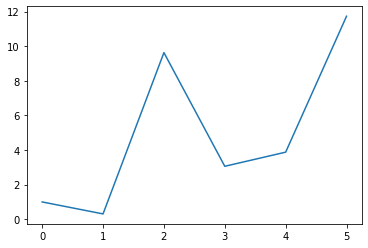

In [15]:
q.plot(np.array(r)[:,1])

In [ ]:
# collect noise samples here
allZ = []

for total_batches in range(total_n_pseudo_batches):
    # sample from latern space to make an image
    z = tf.random.normal([batch_size, z_dim])
    allZ.append(z)
    #pseudo_imgs = generator(z)
    # Generator training
    generator.trainable = True
    student.trainable = False
    for ng in range(ng_batches):
        with tf.GradientTape() as tape:
            pseudo_imgs = generator(z)
            t_logits, *t_acts = teacher(pseudo_imgs)
            s_logits, *_ = student(pseudo_imgs)

            # calculate the generator loss
            sloss = generator_loss_fn(t_logits, s_logits)

            # The grad for generator
            grads = tape.gradient(sloss, generator.trainable_weights)
            grads, _ = tf.clip_by_global_norm(grads, 5.0)
            #generator_optimizer.minimize(sloss_fn, var_list_fn)
            #generator_optimizer.get_gradients(loss, generator.trainable_weights)
            # update the generator paramter with the gradient
            generator_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

            g_loss_met(sloss)

    print('step %s: generator mean loss = %s' % (total_batches, g_loss_met.result().numpy()))
    # ==========================================================================

    # Student training
    generator.trainable = False
    student.trainable = True
    for ns in range(ns_batches):

        #t_logits, *t_acts = teacher(pseudo_imgs)
        with tf.GradientTape() as tape:
            s_logits, *s_acts = student(pseudo_imgs)
            loss = student_loss_fn(t_logits, t_acts, s_logits, s_acts, attn_beta)

        # The grad for student
        grads = tape.gradient(loss, student.trainable_weights)
        grads, _ = tf.clip_by_global_norm(grads, 5.0)
        # Apply grad for student
        student_optimizer.apply_gradients(zip(grads, student.trainable_weights))

        stu_loss_met(loss)
    print(np.argmax(t_logits, axis=-1))
    print(np.argmax(s_logits, axis=-1))
    print('step %s-%s: studnt mean loss = %s' % (total_batches, ns, stu_loss_met.result().numpy()))
    stu_loss_met.reset_states()
    g_loss_met.reset_states()

In [69]:
allZ[0]

<tf.Tensor: id=315071, shape=(128, 100), dtype=float32, numpy=
array([[-1.0358686 , -0.684871  , -0.16783904, ...,  0.5143277 ,
         0.2967401 , -0.5969298 ],
       [-0.49305704,  0.93418497, -0.46287966, ..., -0.67069745,
        -2.2316628 , -0.8568561 ],
       [ 0.04292057, -2.0419998 ,  0.15681241, ...,  2.5317209 ,
        -1.2869126 , -0.20450641],
       ...,
       [-1.1478996 ,  0.12412108, -0.7699375 , ..., -0.56207997,
        -0.7943802 ,  0.660088  ],
       [-0.19442326,  0.25211254,  0.87517554, ..., -0.7135385 ,
         1.5305002 , -1.479154  ],
       [-1.0420706 ,  1.6506463 ,  0.9232475 , ..., -0.73600006,
        -2.8491    , -0.08360916]], dtype=float32)>

In [70]:
allZ[1]

<tf.Tensor: id=327085, shape=(128, 100), dtype=float32, numpy=
array([[-9.7563308e-01,  4.7894308e-01,  8.5420752e-01, ...,
        -1.5680150e+00,  1.3871658e+00,  2.9061723e-01],
       [ 7.2446656e-01,  7.8352824e-02, -1.5123192e+00, ...,
        -5.1941746e-01,  1.7411921e-03, -2.4970953e+00],
       [-1.0857877e+00,  3.2333916e-01, -1.6581066e-01, ...,
         6.6474557e-01,  1.3182930e+00,  1.6273452e+00],
       ...,
       [ 5.2141696e-01,  4.2684895e-01, -5.9079808e-01, ...,
         1.1710562e+00, -9.2736143e-01,  4.9402893e-01],
       [-1.2198722e+00,  6.7198426e-01,  1.1385178e-02, ...,
         7.1641564e-01,  6.5333354e-01,  4.0541831e-01],
       [ 5.6603950e-01,  2.7112632e+00,  4.9270988e-01, ...,
         1.2977178e+00,  7.7176112e-01,  6.8481848e-02]], dtype=float32)>

In [20]:
z = tf.random.normal([128, z_dim])
pseudo_imgs = generator(z)

In [21]:
t_logits, *t_acts = teacher(pseudo_imgs)
#s_logits, *s_acts = student(pseudo_imgs)

In [22]:
np.argmax(t_logits, axis=-1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [23]:
for i in range(100):
    z = tf.random.normal([128, z_dim])
    pseudo_imgs = generator(z)
    t_logits, *t_acts = teacher(pseudo_imgs)
    print(np.argmax(t_logits, axis=-1))

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

KeyboardInterrupt: 

In [113]:
np.argmax(s_logits, axis=-1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [114]:
-tf.keras.losses.kld(tf.math.softmax(t_logits/1), tf.math.softmax(s_logits/1))

<tf.Tensor: id=622519, shape=(128,), dtype=float32, numpy=
array([-16.108494, -16.109707, -16.10695 , -16.114367, -16.10838 ,
       -16.112377, -16.107656, -16.105385, -16.110136, -16.104376,
       -16.112566, -16.108063, -16.113611, -16.104847, -16.114328,
       -16.111156, -16.109795, -16.104095, -16.112213, -16.113987,
       -16.096975, -16.110203, -16.110744, -16.111609, -16.110949,
       -16.105827, -16.11392 , -16.113228, -16.109297, -16.113071,
       -16.11231 , -16.110935, -16.109127, -16.109371, -16.109913,
       -16.112408, -16.107811, -16.10948 , -16.113201, -16.109617,
       -16.106361, -16.108526, -16.108309, -16.109287, -16.111029,
       -16.111767, -16.11352 , -16.112497, -16.112753, -16.10953 ,
       -16.111723, -16.110271, -16.11001 , -16.10771 , -16.114899,
       -16.100468, -16.104774, -16.112808, -16.106663, -16.10405 ,
       -16.112036, -16.11499 , -16.108482, -16.112381, -16.112026,
       -16.108225, -16.112162, -16.110857, -16.112865, -16.105967,
   

In [98]:
tf.nn.softmax(t_logits)

<tf.Tensor: id=619262, shape=(128, 10), dtype=float32, numpy=
array([[1.73236019e-13, 5.79287418e-09, 9.99720991e-01, ...,
        4.44518608e-13, 1.70145104e-05, 2.86930032e-07],
       [1.80258721e-13, 5.59302693e-09, 9.99660611e-01, ...,
        6.18259675e-13, 1.23469435e-05, 4.27991495e-07],
       [1.41766265e-13, 5.77035930e-09, 9.99742448e-01, ...,
        4.22092726e-13, 1.65913025e-05, 2.08873786e-07],
       ...,
       [2.67805445e-13, 6.51081722e-09, 9.99684572e-01, ...,
        8.87235055e-13, 2.01805778e-05, 2.69925721e-07],
       [2.05917816e-13, 5.73566616e-09, 9.99714553e-01, ...,
        7.36191761e-13, 2.07085886e-05, 1.60248504e-07],
       [1.41627270e-13, 6.21082918e-09, 9.99682784e-01, ...,
        4.30357600e-13, 1.29865775e-05, 4.32773618e-07]], dtype=float32)>

In [62]:
t_logits.shape

TensorShape([128, 10])

In [74]:
np.argmax(t_logits, axis=-1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [75]:
np.argmax(s_logits, axis=-1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [93]:
-tf.keras.losses.kld(tf.math.softmax(t_logits/1), tf.math.softmax(s_logits/1))

<tf.Tensor: id=618202, shape=(128,), dtype=float32, numpy=
array([-16.113594, -16.113438, -16.105751, -16.11192 , -16.103193,
       -16.112785, -16.109215, -16.10962 , -16.110657, -16.113207,
       -16.106478, -16.107164, -16.109896, -16.112822, -16.110554,
       -16.109566, -16.11013 , -16.111303, -16.10878 , -16.110264,
       -16.113176, -16.113718, -16.112478, -16.1068  , -16.111942,
       -16.107141, -16.105663, -16.108484, -16.109747, -16.109455,
       -16.11235 , -16.114386, -16.108665, -16.110588, -16.11215 ,
       -16.108305, -16.109087, -16.10959 , -16.10536 , -16.110159,
       -16.114157, -16.105764, -16.110926, -16.105675, -16.107052,
       -16.108885, -16.104893, -16.110935, -16.113972, -16.112383,
       -16.113396, -16.112322, -16.10848 , -16.108068, -16.108719,
       -16.111391, -16.106165, -16.100979, -16.11092 , -16.112635,
       -16.114119, -16.1098  , -16.111538, -16.110523, -16.112242,
       -16.113146, -16.111383, -16.107435, -16.10939 , -16.113394,
   

In [17]:
tf.nn.softmax(t_logits, axis=1)[0]

<tf.Tensor: id=8035, shape=(10,), dtype=float32, numpy=
array([6.0265061e-06, 1.8073046e-05, 9.2791719e-04, 9.9107856e-01,
       5.3548539e-04, 7.1743317e-04, 9.7325142e-04, 4.1424406e-07,
       5.7407082e-03, 2.1374408e-06], dtype=float32)>

In [55]:
s_logits[66]

<tf.Tensor: id=299831, shape=(10,), dtype=float32, numpy=
array([-4.3618917 , -8.372073  ,  0.17348364, 14.385825  , -6.7830644 ,
       -8.034959  , -5.2229996 , -7.9174027 ,  0.16598235, -2.6487436 ],
      dtype=float32)>

In [53]:
tf.math.softmax(t_logits)[66]

<tf.Tensor: id=299823, shape=(10,), dtype=float32, numpy=
array([3.99472205e-10, 2.03878251e-11, 1.06562815e-07, 9.99999881e-01,
       1.60894898e-13, 1.26279920e-09, 9.63189354e-14, 3.97031156e-16,
       1.53560169e-08, 1.24514396e-12], dtype=float32)>

In [52]:
tf.math.softmax(s_logits)[66]

<tf.Tensor: id=299818, shape=(10,), dtype=float32, numpy=
array([7.2105664e-09, 1.3072833e-10, 6.7244684e-07, 9.9999857e-01,
       6.4042349e-10, 1.8313721e-10, 3.0478569e-09, 2.0598252e-10,
       6.6742132e-07, 3.9992649e-08], dtype=float32)>

In [39]:
np.average(-tf.keras.losses.kld(tf.math.softmax(t_logits/1), tf.math.softmax(s_logits/1)))

-1.7291103e-06

In [41]:
-tf.keras.losses.kld(tf.math.softmax(t_logits/1), tf.math.softmax(s_logits))

<tf.Tensor: id=299768, shape=(128,), dtype=float32, numpy=
array([-7.1930992e-07, -1.4643133e-06, -3.9379993e-06, -1.1229838e-06,
       -1.3483844e-06, -2.1163869e-06, -1.7904100e-06, -1.2343418e-06,
       -8.3294566e-07, -2.9433027e-06, -2.3060079e-06, -2.3060886e-06,
       -4.6132254e-06, -4.0136135e-07, -2.1978351e-06, -1.1228403e-06,
       -1.9052153e-06, -9.9882197e-07, -1.1318238e-06, -2.9723235e-06,
       -2.9776870e-06, -4.5917216e-07, -6.3910602e-07, -1.1353343e-06,
       -1.5817259e-06, -2.1214680e-06, -1.1263053e-06, -2.1903036e-06,
       -3.0410292e-06, -1.5713857e-06, -4.9523514e-06, -5.0400854e-07,
       -2.2257009e-06, -1.1359920e-06, -1.4554205e-06, -9.0088275e-07,
       -2.1262892e-06, -1.0383005e-06, -2.0847315e-06, -1.6683788e-06,
       -1.1373497e-06, -1.0234830e-06, -4.1982997e-07, -5.9526428e-07,
       -9.1840212e-07, -8.2094726e-07, -1.4476336e-06, -8.9536110e-07,
       -3.5031110e-06, -6.2645017e-07, -1.1316400e-06, -2.8427962e-06,
       -2.4084102e

In [21]:
tf.nn.softmax(s_logits)[0]

<tf.Tensor: id=8284, shape=(10,), dtype=float32, numpy=
array([0.09966495, 0.10159311, 0.1002707 , 0.09997319, 0.09979188,
       0.1008326 , 0.09929379, 0.09801106, 0.10015489, 0.10041383],
      dtype=float32)>

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
from utils.preprocess import load_cifar10_data

In [7]:
(x_train, y_train), (x_test, y_test) = load_cifar10_data()

In [36]:
def get_accuracy(student):
    model = WideResidualNetwork(16, 1, input_shape=(32, 32, 3), dropout_rate=0.0)
    model.set_weights(student.get_weights()) 
    model.compile(loss='categorical_crossentropy',
                      metrics=['accuracy'])
    loss, accuracy = model.evaluate(x_test, y_test, batch_size=128, verbose=0)
    return loss, accuracy

In [29]:
stest = student(x_test)

TypeError: call() got an unexpected keyword argument 'batch_size'

In [26]:
import timeit

In [45]:
%%time
get_accuracy(student)

Wall time: 8.73 s


(29.924496099853517, 0.1)

In [44]:
student.trainable = False

In [13]:
a = True
b = False

In [17]:
if a and not b:
    print("yes")

yes


In [33]:
%%time
model = WideResidualNetwork(16, 1, input_shape=(32, 32, 3), dropout_rate=0.0)
model.set_weights(student.get_weights()) 
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Wall time: 577 ms


In [31]:
%%time
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 2.3115152214050294
Test accuracy: 0.1098
Wall time: 7.44 s


In [39]:
0%11

0

In [40]:
10%11

10

In [41]:
11%11

0

In [42]:
12%11

1

In [43]:
1%11

1

In [49]:
ip = 0
npb = 0
tnpb = 2
nrb = 11
ng = 1
ns = 10
while npb < tnpb:
    if ip % nrb < ng:
        print("gen update")
    elif ip % nrb < (ng+ns):
        print("student update")
    if (ip+1) % nrb == 0:
        npb += 1
    ip += 1

gen update
student update
student update
student update
student update
student update
student update
student update
student update
student update
student update
gen update
student update
student update
student update
student update
student update
student update
student update
student update
student update
student update


In [50]:
8e4

80000.0

In [74]:
student_optimizer.learning_rate(80001).numpy()

0.0

In [30]:
generator(z)

<tf.Tensor: id=8540, shape=(128, 32, 32, 3), dtype=float32, numpy=
array([[[[ 4.22538724e-03,  5.52038196e-03,  2.78851506e-03],
         [ 1.51259303e-02, -7.12775532e-03, -8.53509177e-03],
         [ 2.65080691e-03, -1.44896386e-02, -4.11295658e-03],
         ...,
         [-3.22682608e-04, -9.70256235e-03,  3.45329754e-03],
         [-8.36795475e-03, -1.96127128e-02,  7.81526230e-03],
         [-1.02375029e-03, -1.18294591e-02,  1.71103310e-02]],

        [[-2.88313581e-03,  4.60245833e-03, -4.73300321e-03],
         [-2.09012460e-02,  8.04036763e-03,  4.24172403e-03],
         [-1.87908225e-02, -2.52782665e-02, -1.08433794e-03],
         ...,
         [-1.77930836e-02,  1.47952419e-02, -1.38257826e-02],
         [-1.23509280e-02, -2.97810733e-02, -2.96389940e-03],
         [-8.16030428e-03, -4.22601867e-03, -4.11631120e-03]],

        [[ 1.00406213e-02, -1.96873280e-03, -2.75179697e-03],
         [ 2.50531198e-03, -1.12852873e-02,  1.28602535e-02],
         [ 1.53854266e-02, -1.006

In [32]:
generator(z)

<tf.Tensor: id=8850, shape=(128, 32, 32, 3), dtype=float32, numpy=
array([[[[ 4.22538724e-03,  5.52038196e-03,  2.78851506e-03],
         [ 1.51259303e-02, -7.12775532e-03, -8.53509177e-03],
         [ 2.65080691e-03, -1.44896386e-02, -4.11295658e-03],
         ...,
         [-3.22682608e-04, -9.70256235e-03,  3.45329754e-03],
         [-8.36795475e-03, -1.96127128e-02,  7.81526230e-03],
         [-1.02375029e-03, -1.18294591e-02,  1.71103310e-02]],

        [[-2.88313581e-03,  4.60245833e-03, -4.73300321e-03],
         [-2.09012460e-02,  8.04036763e-03,  4.24172403e-03],
         [-1.87908225e-02, -2.52782665e-02, -1.08433794e-03],
         ...,
         [-1.77930836e-02,  1.47952419e-02, -1.38257826e-02],
         [-1.23509280e-02, -2.97810733e-02, -2.96389940e-03],
         [-8.16030428e-03, -4.22601867e-03, -4.11631120e-03]],

        [[ 1.00406213e-02, -1.96873280e-03, -2.75179697e-03],
         [ 2.50531198e-03, -1.12852873e-02,  1.28602535e-02],
         [ 1.53854266e-02, -1.006

In [28]:
2e-3

0.002

In [24]:
def evaluate(data_loader, model, output_activations=True):
    total = 0
    correct = 0
    for inputs, labels in data_loader:
        if output_activations:
            out, *_ = model(inputs, training=False)
        else:
            out = model(inputs, training=False)

        prob = tf.math.softmax(out, axis=-1)
        # prob = prob.numpy()

        pred = tf.argmax(prob, axis=-1)
        equality = tf.math.equal(pred.numpy(), tf.reshape(labels, [-1]).numpy())
        correct += tf.reduce_sum(tf.cast(equality, tf.float32))
        total += equality.shape[0]

    ret = correct / tf.cast(total, tf.float32)
    return ret.numpy()

In [25]:
from utils.preprocess import get_cifar10_data
(_, _), (x_test, y_test) = get_cifar10_data()

test_data_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(200)

In [26]:
evaluate(test_data_loader, teacher)

0.947